In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

live_lbls = [0,1,6]
class AsymAdditiveMarginSoftmax(nn.Module):
    def __init__(self, in_features, out_features, s=30, ml=0.4,ms=0.1):
        super(AsymAdditiveMarginSoftmax, self).__init__()
        self.s = s
        self.ml = ml
        self.ms = ms
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
    def forward(self, x, labels):
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        m = torch.tensor([[self.ml if lbl in live_lbls else self.ms for lbl in labels]]).to(device)
        self.fc.weight.data = F.normalize(self.fc.weight.data, p=2, dim=1)
        x = F.normalize(x, p=2, dim=1)
        wf = self.fc(x)
        out = F.softmax(self.s*wf)
        numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - m)
        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return out, -torch.mean(L)

In [16]:
from torchvision.models.resnet import resnet18

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.encoder = resnet18(pretrained=True)
        self.encoder.requires_grad = False
        self.encoder.fc = nn.Sequential()
        self.ams = AsymAdditiveMarginSoftmax(512,9)
    def forward_once(self,input,labels):
        f = self.encoder(input)
        out, loss = self.ams(f,labels)
        return out, f, loss
    
    def forward(self, input1, input2,labels):
        out1, f1, loss1 = self.forward_once(input1,labels)
        out2, f2, loss2 = self.forward_once(input2,labels)
        f1_norm = F.normalize(f1,p=2,dim=1)
        f2_norm = F.normalize(f2,p=2,dim=1)
        loss =  loss1 + loss2 + torch.mean(torch.norm(f1_norm-f2_norm))
        return out1, out2, loss

In [17]:
from torch.utils.data import Dataset
from PIL import Image
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
    def __getitem__(self,index):   
        data = self.imageFolderDataset.imgs[index]
        img = Image.open(data[0])
        img0 = self.transform[0](img)
        img1 = self.transform[1](img)
        return img0, img1, data[1]
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
class TestDataset(Dataset):
    def __init__(self,imageFolderDataset,transform):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
    def __getitem__(self,index):   
        data = self.imageFolderDataset.imgs[index]
        img = Image.open(data[0])
        img = self.transform(img)
        return img, data[1]
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [18]:
from torchvision.transforms.transforms import CenterCrop
import time
import copy
from torchvision import datasets, transforms
import os
import torch

data_transforms = {
    'train': [
        transforms.Compose([
          transforms.RandomRotation(180),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomCrop(100),
          transforms.ToTensor(),
        ]),
        transforms.Compose([
          transforms.RandomRotation(180),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomCrop(100),
          transforms.ToTensor(),
        ]),
    ],
    'test': transforms.Compose([
          transforms.RandomRotation(180),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.RandomCrop(100),
          transforms.ToTensor(),
        ]),
}
data_dir = '/content/drive/MyDrive/casia'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train')),
     'test': datasets.ImageFolder(os.path.join(data_dir, 'test'))
}
siameseDataset = SiameseNetworkDataset(image_datasets['train'],data_transforms['train'])
testDataset = TestDataset(image_datasets['test'], data_transforms['test'])
dataloaders = {
    'train': torch.utils.data.DataLoader(siameseDataset,shuffle=True,num_workers=2),
    'test': torch.utils.data.DataLoader(testDataset,shuffle=True,num_workers=2)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}
class_names = image_datasets['train'].classes

In [19]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

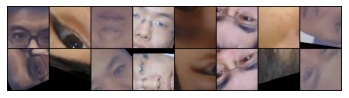

[5 6 3 5 7 4 8 3]


In [20]:
vis_dataloader = torch.utils.data.DataLoader(siameseDataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)
example_batch = next(iter(vis_dataloader))
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

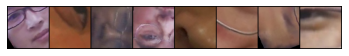

[2 7 5 2 6 6 2 8]


In [21]:
vis_dataloader = torch.utils.data.DataLoader(testDataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)
example_batch = next(iter(vis_dataloader))
concatenated = example_batch[0]
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[1].numpy().reshape(-1))

In [25]:
loss_history_train = []
loss_history_test = []
acc_history_train = []
acc_history_test = []

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 40)
        for phase in ['train' , 'test']:
            if phase == 'train':
                model.train()
            running_loss = 0.0
            running_corrects = 0
            for dataloader in dataloaders[phase]:
                optimizer.zero_grad()
                if phase == 'train':
                  inputs1, inputs2, labels = dataloader
                  inputs1 = inputs1.to(device)
                  inputs2 = inputs2.to(device)
                  labels = labels.to(device)
                  out1, out2, loss = model(inputs1, inputs2, labels)
                  loss.backward()
                  optimizer.step()
                  _, preds = torch.max(out1,1)
                  running_corrects += torch.sum(preds == labels.data)
                  running_loss += loss.item() * inputs1.size(0)
                else:
                  inputs, labels = dataloader
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  with torch.no_grad():
                    out, f, loss = net.forward_once(inputs, labels)
                  _, preds = torch.max(out,1)
                  running_corrects += torch.sum(preds == labels.data)
                  running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'train':
              scheduler.step()
              loss_history_train.append(epoch_loss)
              acc_history_train.append(epoch_acc.cpu().detach().numpy())
            else:
              loss_history_test.append(epoch_loss)
              acc_history_test.append(epoch_acc.cpu().detach().numpy())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model
net = SiameseNetwork().to(device)
optimizer = optim.SGD(net.parameters(), lr = 0.002 )
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=90, gamma=0.5)
net = train_model(net,optimizer,exp_lr_scheduler,200)


Epoch 1/200
----------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 19.3015 Acc: 0.1222
test Loss: 10.2233 Acc: 0.1111

Epoch 2/200
----------------------------------------
train Loss: 18.7525 Acc: 0.1389
test Loss: 8.8522 Acc: 0.2062

Epoch 3/200
----------------------------------------
train Loss: 18.3327 Acc: 0.1667
test Loss: 8.7024 Acc: 0.2173

Epoch 4/200
----------------------------------------
train Loss: 18.0328 Acc: 0.1963
test Loss: 9.4142 Acc: 0.1975

Epoch 5/200
----------------------------------------
train Loss: 17.8940 Acc: 0.2074
test Loss: 8.4071 Acc: 0.2481

Epoch 6/200
----------------------------------------
train Loss: 17.6007 Acc: 0.2537
test Loss: 8.8876 Acc: 0.2617

Epoch 7/200
----------------------------------------
train Loss: 17.4767 Acc: 0.2722
test Loss: 8.4048 Acc: 0.3025

Epoch 8/200
----------------------------------------
train Loss: 17.2967 Acc: 0.3093
test Loss: 9.3758 Acc: 0.1926

Epoch 9/200
----------------------------------------
train Loss: 16.8644 Acc: 0.3259
test Loss: 7.8641 Acc: 0.3741

Epoch 10

In [ ]:
plt.plot(loss_history_train,c='r')
plt.plot(loss_history_test,c='b')
plt.show()

In [ ]:
plt.plot(acc_history_train,c='r')
plt.plot(acc_history_test,c='b')
plt.show()

In [ ]:
class PatchNet(nn.Module):
    def __init__(self):
        super(PatchNet,self).__init__()
        self.encoder = resnet18()
        self.encoder.fc = nn.Sequential()
        self.fc = nn.Linear(512,9, bias=False)
    def forward(self,x):
        x = self.encoder(x)
        self.fc.weight.data = F.normalize(self.fc.weight.data, p=2, dim=1) 

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
        x = F.softmax(30 * wf)
        return x

model = PatchNet().cuda()
model.encoder = net.encoder
model.fc = net.ams.fc
torch.save(model,'/content/drive/MyDrive/casia/patchnet.pt')

In [ ]:
running_corrects = 0
for i, (img1, label) in enumerate(dataloaders['test']):
        img1, label = img1.cuda(), label.cuda()
        with torch.no_grad():
            output = model(img1)
            _, preds = torch.max(output,1)
        running_corrects += torch.sum(preds == label.data)
acc = running_corrects/dataset_sizes['test']
print(f'Acc: {acc:.4f}')
  